In [1]:
import numpy as np

# 关于pyrdown

In [1]:
def pyrdown(image_size, min_face=12, max_face=0, factor=0.709):
    image_width, image_height = image_size
    m = 12 / min_face  # 12   m = 1,    24    m  0.5
    minl = min(image_width, image_height)
    scale = 1.0
    scales_select = []
    # 如果原始1.0比例的时候，是一个像素单位，那么当比例达到一定值的小的时候，像素值代表更大的图，此时这个代表如果超过最大人脸则不需要
    min_scale = 12 / max_face if max_face != 0 else 0

    minl *= m  # 
    while minl >= 12.0 and m * scale >= min_scale:
        scales_select.append(m * scale)
        scale *= factor
        minl *= factor

    if len(scales_select) == 0:
        return []

    return scales_select

In [2]:
pyrdown([1000, 800], 30, 100)

[0.4, 0.2836, 0.20107239999999998, 0.14256033159999998]

In [9]:
"所需要的比例范围是：%.2f - %.2f" % (12 / 30, 12 / 100)

'所需要的比例范围是：0.40 - 0.12'

- 比例的案例图
- <img src="miku.png"/>

In [2]:
begin  = 12 / 30  # 其实比例
end    = 12 / 100   # 终止比例
factor = 0.709   # 缩放系数，两个比例之间的缩放
min_line = 800          # 图像的短边

scale = begin    # 起始时指定scale
while scale >= end and scale * min_line >= 12:
     # 如果当前的scale已经小于终止比例，或者当前scale乘以短边小于12，都不需要了
    print(scale)
    scale = scale * factor   # 对当前使用的scale进行缩放得到新的scale
    min_line *= scale

0.4
0.2836


In [30]:
import cv2
import matplotlib.pyplot as plt

In [22]:
image = cv2.imread("miku.png")

In [25]:
begin  = 12 / 30  # 其实比例
end    = 12 / 100   # 终止比例
factor = 0.709   # 缩放系数，两个比例之间的缩放
min_line = min(image.shape[:2])          # 图像的短边

scale = begin    # 起始时指定scale
scales = []

while scale >= end and scale * min_line >= 12:
    scales.append(scale)
    scale = scale * factor   # 对当前使用的scale进行缩放得到新的scale

scales

[0.4, 0.2836, 0.2010724, 0.1425603316]

In [27]:
pyrs = [cv2.resize(image, dsize=None, fx=scale, fy=scale) for scale in scales]

In [32]:
show = pyrs[0]
image_height, image_width = show.shape[:2]
for pyr_image in pyrs:
    
    pyr_height, pyr_width = pyr_image.shape[:2]
    show[image_height - pyr_height:, image_width - pyr_width:] = pyr_image

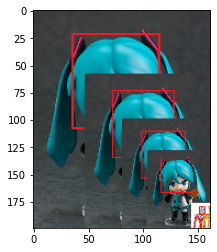

In [33]:
plt.imshow(show[..., ::-1])

# 关于warpAffine
- 向量vector的表达：(x, y, 0)，表达了向量$\vec{xy}$
- 点point的表达：(x, y, w) (w != 0)，表达了点$(\frac{x}{w}, \frac{y}{w})$
- 则有：
    - point + vector = point
    - point + point = point
    - vector + vector = vector

- 旋转矩阵R，二维y轴朝下时（图像坐标系，OpenCV的旋转方式）$
R = \left[
\begin{array}{rcl}
\cos\theta & \sin\theta \\
-\sin\theta & \cos\theta
\end{array}
\right]
$
- 平移矩阵T，二维y轴朝下时（图像坐标系）$
T = \left[
\begin{array}{rcl}
tx \\
ty
\end{array}
\right]
$

- 对一个点$P = \left[
\begin{array}{rcl}
x \\
y
\end{array}
\right]$进行旋转后平移，则写成：$RP + T = \hat P$
    - $\left[
\begin{array}{rcl}
\cos\theta & \sin\theta \\
-\sin\theta & \cos\theta
\end{array}
\right]  \left[\begin{array}{rcl}x \\y\end{array}\right] + \left[
\begin{array}{rcl}
tx \\
ty
\end{array}
\right] = \left[
\begin{array}{rcl}
\hat x \\
\hat y
\end{array}
\right]$

- 2x2矩阵无法合并平移变换。为了合并为一个矩阵表达变换 ，引入齐次坐标表示（Homogeneous coordinates）
    - $P = \left[
\begin{array}{rcl}
x \\
y \\
1
\end{array}
\right]$ 表示一个点，方式是(x, y, w)(w != 0)，表达的是点$(\frac{x}{w}, \frac{y}{w})$

- 此时，旋转矩阵R，二维y轴朝下时（图像坐标系）$
R = \left[
\begin{array}{rcl}
\cos\theta & \sin\theta & 0\\
-\sin\theta & \cos\theta & 0\\
0 & 0 & 1
\end{array}
\right]
$
- 此时，平移矩阵T，二维y轴朝下时（图像坐标系）$
T = \left[
\begin{array}{rcl}
1 & 0 & tx \\
0 & 1 & ty \\
0 & 0 & 1
\end{array}
\right]
$

- 对一个点$P = \left[
\begin{array}{rcl}
x \\
y \\
1
\end{array}
\right]$进行旋转后平移，则写成：$TRP = \hat P$
    - $\left[
\begin{array}{rcl}
1 & 0 & tx \\
0 & 1 & ty \\
0 & 0 & 1
\end{array}
\right] \left[
\begin{array}{rcl}
\cos\theta & \sin\theta & 0\\
-\sin\theta & \cos\theta & 0\\
0 & 0 & 1
\end{array}
\right]  \left[\begin{array}{rcl}x \\ y \\ 1\end{array}\right] = \left[
\begin{array}{rcl}
\hat x \\
\hat y \\
w
\end{array}
\right]$

- 其中TR可以合并为一个矩阵M，$M = TR =\left[
\begin{array}{rcl}
\cos\theta & \sin\theta & tx\\
-\sin\theta & \cos\theta & ty\\
0 & 0 & 1
\end{array}
\right]$

- 对于opencv中的仿射变换矩阵，只需要考虑旋转、缩放、平移，因此第三行恒等于0， 0， 1.所以储存时可以不考虑0， 0， 1只保留2x3矩阵

- 结论：
    1. 对于变换操作，左乘一个3x3矩阵即对目标做一次变换
        - 变换先后顺序是有定义的，这也与矩阵乘法大部分时候没有交换律一样
        - 比如先平移后旋转，先旋转后平移是不同的
        - 旋转、缩放、平移永远都是相对原点进行的。如果需要相对不同点，则可以TRT，第一个T是把特定点平移到原点，R做旋转，第二个T是把原点平移到目标点
    2. 对于变换矩阵，可以把所有左乘的矩阵乘在一起，作为最终的变换矩阵。这也与矩阵乘法的分配律一样
    - 因此当遇到需要考虑的变换时，可以考虑分解为多个操作的联合实现

# 具体测试案例

In [ ]:
miku = cv2.imread("affine.test.png")

def affine_show(M):
    M = M[:2].astype(np.float32)
    show = cv2.warpAffine(miku, M, (400, 400))
    plt.imshow(show[..., ::-1])

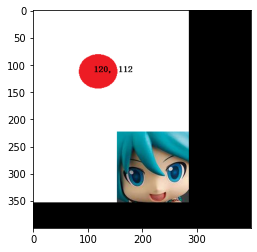

In [61]:
affine_show(np.eye(3))

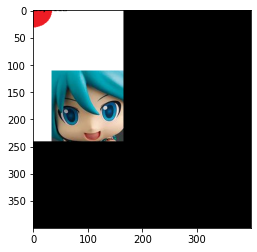

In [62]:
x = 120
y = 112

T = np.array([
    [1, 0, -x],
    [0, 1, -y],
    [0, 0, 1]
])
affine_show(T)

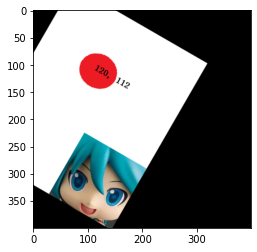

In [76]:
x = 120
y = 112

T = np.array([
    [1, 0, -x],
    [0, 1, -y],
    [0, 0, 1]
])

theta = 30 / 180 * np.pi
R = np.array([
    [np.cos(theta), -np.sin(theta), 0],
    [np.sin(theta), np.cos(theta), 0],
    [0, 0, 1]
])

T2 = np.array([
    [1, 0, x],
    [0, 1, y],
    [0, 0, 1]
])
affine_show(T2 @ R @ T)

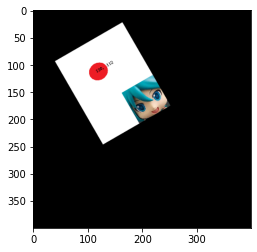

In [80]:
x = 120
y = 112

T = np.array([
    [1, 0, -x],
    [0, 1, -y],
    [0, 0, 1]
])

S = np.array([
    [0.5, 0, 0],
    [0, 0.5, 0],
    [0, 0, 1]
])

theta = 30 / 180 * np.pi
R = np.array([
    [np.cos(theta), np.sin(theta), 0],
    [-np.sin(theta), np.cos(theta), 0],
    [0, 0, 1]
])

T2 = np.array([
    [1, 0, x],
    [0, 1, y],
    [0, 0, 1]
])
affine_show(T2 @ R @ S @ T)

In [81]:
cv2.getRotationMatrix2D((x, y), 30, 0.5)

array([[ 0.4330127 ,  0.25      , 40.03847577],
       [-0.25      ,  0.4330127 , 93.50257739]])

In [82]:
T2 @ R @ S @ T

array([[ 0.4330127 ,  0.25      , 40.03847577],
       [-0.25      ,  0.4330127 , 93.50257739],
       [ 0.        ,  0.        ,  1.        ]])

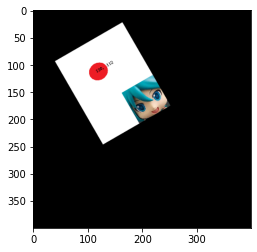

In [83]:
affine_show(cv2.getRotationMatrix2D((x, y), 30, 0.5))